# Data cleaning and EDA for Santender dataset

### Import relevant libraries
Please remove libraries that youre not using.....

## Table of Contents
1. Data source
2. Imports and Data Ingestion
3. Data Cleaning
4. Data exploration
4. Feature selection and engineering
5. Using SMOTE to resolve imbalance in dataset

## 1) Data Source
WIP: briefly explain dataset (spanish, context, etc)

## 2) Imports and Data Ingestion

In [810]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import median
from imblearn.over_sampling import SMOTE #Note to add this to requirements.txt, conda install -c conda-forge imbalanced-learn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder



In [811]:
## Set the names of the files to clean and the name of the cleaned files here:
raw_data_file = "recodataset.csv"
clean_train = "clean_train_reco.csv"
clean_test = "clean_test_reco.csv"
#Number below determines size of cleaned dataset, which is this number * number of products * 2
#in this case dataset size is about 15000*8 = 120000 rows
number_of_each_class = 15000 

Read in raw data into df

In [812]:
print("Current Working Directory:", os.getcwd()) 

# Define file paths for training and testing data
raw_file_path = os.path.join("../..", "data", raw_data_file)  

# Print the paths to verify
print("Raw Data Path:", raw_file_path)

# Read the raw CSV file
df = pd.read_csv(raw_file_path)

Current Working Directory: /Users/collinsng/Desktop/DSA3101/Project/OpenAYEye/notebook/reco_system
Raw Data Path: ../../data/recodataset.csv


## 3) Data renaming and cleaning

In [813]:
output_file_path = clean_train  # output training CSV file

# Define the mapping of original Spanish column names to English column names
column_mapping = {
    "fecha_dato": "report_date",
    "ncodpers": "customer_id",
    "ind_empleado": "employee_index",
    "pais_residencia": "country_residence",
    "sexo": "gender",
    "age": "age",
    "fecha_alta": "contract_start_date",
    "ind_nuevo": "new_customer_index",
    "antiguedad": "seniority_months",
    "indrel": "primary_customer_status",
    "ult_fec_cli_1t": "last_primary_customer_date",
    "indrel_1mes": "customer_type_start_month",
    "tiprel_1mes": "customer_relation_type",
    "indresi": "residence_index",
    "indext": "foreigner_index",
    "conyuemp": "spouse_employee_index",
    "canal_entrada": "join_channel",
    "indfall": "deceased_index",
    "tipodom": "address_type",
    "cod_prov": "province_code",
    "nomprov": "province_name",
    "ind_actividad_cliente": "activity_index",
    "renta": "gross_income",
    "segmento": "customer_segment",
    "ind_ahor_fin_ult1": "saving_account",
    "ind_aval_fin_ult1": "guarantee",
    "ind_cco_fin_ult1": "current_account",
    "ind_cder_fin_ult1": "derivada_account",
    "ind_cno_fin_ult1": "payroll_account",
    "ind_ctju_fin_ult1": "junior_account",
    "ind_ctma_fin_ult1": "more_particular_account",
    "ind_ctop_fin_ult1": "particular_account",
    "ind_ctpp_fin_ult1": "particular_plus_account",
    "ind_deco_fin_ult1": "short_term_deposits",
    "ind_deme_fin_ult1": "medium_term_deposits",
    "ind_dela_fin_ult1": "long_term_deposits",
    "ind_ecue_fin_ult1": "e_account",
    "ind_fond_fin_ult1": "funds",
    "ind_hip_fin_ult1": "mortgage",
    "ind_plan_fin_ult1": "pensions",
    "ind_pres_fin_ult1": "loans",
    "ind_reca_fin_ult1": "taxes",
    "ind_tjcr_fin_ult1": "credit_card",
    "ind_valo_fin_ult1": "securities",
    "ind_viv_fin_ult1": "home_account",
    "ind_nomina_ult1": "payroll",
    "ind_nom_pens_ult1": "pensions_payments",
    "ind_recibo_ult1": "direct_debit"
}
# Rename the columns to english
df.rename(columns=column_mapping, inplace=True)

Suggestion: create a chunk of code for feature selection -> add correlation matrix + drop columns    
use another chunk of code for file renaming

### Regrouping bank products into 4 main categories
- fixed-deposits
- loan
- accounts
- credit and debit cards


Rationale: There are 25 products provided by this bank. In order to improve the ease of understanding our system, we simplified the problem of ranking 25 products to 4 products instead. We do this by grouping the 25 different products into 4 categories of products. 

In [814]:
# Define new column names
fixed_deposits_col = 'fixed_deposits'
loan_col = 'loan'
credit_card_debit_card_col = 'credit_card_debit_card'
account_col = 'account'

# Check and create a new column for fixed deposits, if it doesn't exist
if fixed_deposits_col not in df.columns:
    deposit_columns = [
        "short_term_deposits",  # ind_deco_fin_ult1
        "medium_term_deposits",  # ind_deme_fin_ult1
        "long_term_deposits"    # ind_dela_fin_ult1
    ]
    df[fixed_deposits_col] = df[deposit_columns].any(axis=1).astype(int)

# Check and create a new column for loans, if it doesn't exist
if loan_col not in df.columns:
    loan_columns = [
        "loans",                # ind_pres_fin_ult1
        "pensions"             # ind_plan_fin_ult1
    ]
    df[loan_col] = df[loan_columns].any(axis=1).astype(int)

# Check and create a new column for credit and debit cards, if it doesn't exist
if credit_card_debit_card_col not in df.columns:
    credit_card_columns = [
        "credit_card",         # ind_tjcr_fin_ult1
        "direct_debit"        # ind_recibo_ult1
    ]
    df[credit_card_debit_card_col] = df[credit_card_columns].any(axis=1).astype(int)

# Check and create a new column for all accounts combined, if it doesn't exist
if account_col not in df.columns:
    account_columns = [
        "saving_account",      # ind_ahor_fin_ult1
        "current_account",     # ind_cco_fin_ult1
        "derivada_account",    # ind_cder_fin_ult1
        "payroll_account",     # ind_cno_fin_ult1
        "junior_account",      # ind_ctju_fin_ult1
        "more_particular_account",  # ind_ctma_fin_ult1
        "particular_account",   # ind_ctop_fin_ult1
        "particular_plus_account", # ind_ctpp_fin_ult1
        "e_account",           # ind_ecue_fin_ult1
        "funds",               # ind_fond_fin_ult1
        "home_account",        # ind_viv_fin_ult1
    ]
    df[account_col] = df[account_columns].any(axis=1).astype(int)

# Remove these columns as they have been grouped into the 4 larger categories of products
columns_to_drop = [
    'saving_account', 'guarantee', 'current_account', 'derivada_account', 'payroll_account', 
    'junior_account', 'more_particular_account', 'particular_account', 'particular_plus_account', 
    'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 
    'mortgage', 'pensions', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 
    'payroll', 'pensions_payments', 'direct_debit', 'employee_index'
]

# Drop the columns if they exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### Dealing with missing values in data
Since "Gross income" and "age" are crucial features in determining a customer's economic status, which influences their likelihood of purchasing a product, we cannot discard these columns entirely. Additionally, dropping rows without values in this field is not justifiable, as we cannot compel customers to disclose their income in real life. Therefore, we will be imputing the median value for the NaN cells in this column.
For the remaining columns we can drop the rows with NA values

In [815]:
## Replace missing values in gross income and age with median of distribution
count = df['gross_income'].isna().sum()
df['gross_income'] = df['gross_income'].fillna(df['gross_income'].median())

df['age'] = pd.to_numeric(df['age'].replace(' NA', None), errors='coerce')
med_age = df['age'].median()
df['age'] = df['age'].fillna(med_age).astype(int)


### Analysising distribution of gross_income and age
majority of the customers are etween 20-29 years old and the mode of income is between 30-100k

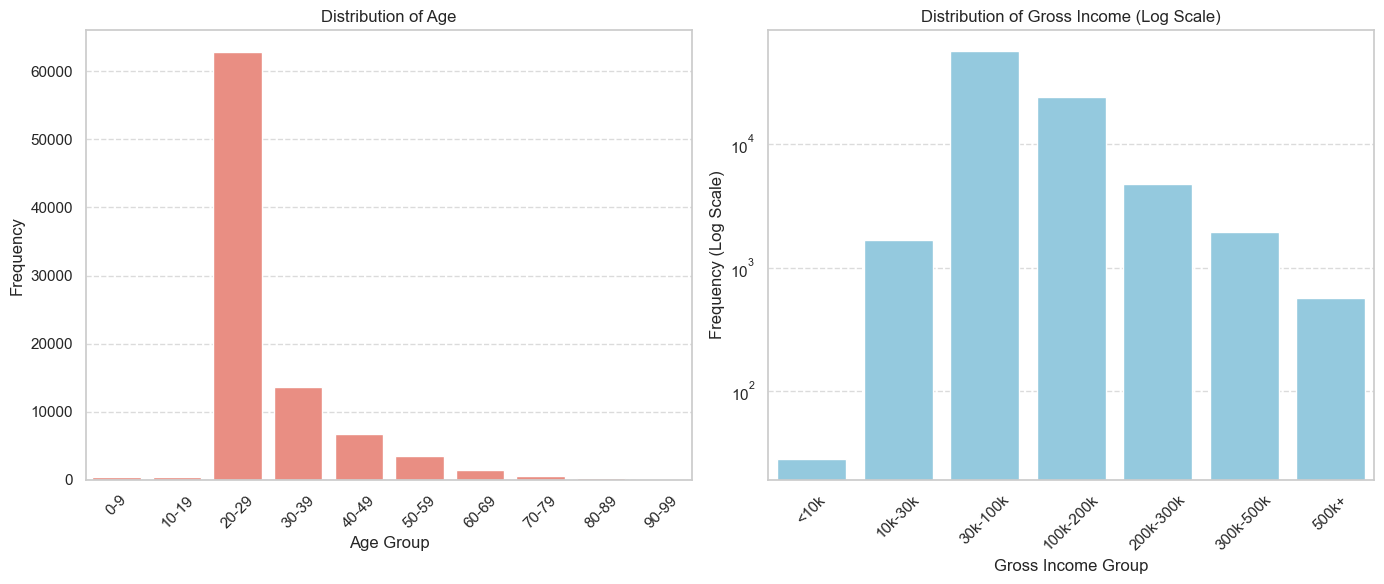

In [816]:

# Create a temporary DataFrame for age groups
temp_age_df = df[['age']].copy()
# Create age groups in 10-year intervals
age_bins = range(0, 101, 10)  # 0-100 years
age_labels = [f"{i}-{i+9}" for i in age_bins[:-1]]  # e.g., '0-9', '10-19', ..., '90-99'

temp_age_df['age_group'] = pd.cut(temp_age_df['age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of occurrences in each age group
age_counts = temp_age_df['age_group'].value_counts().reindex(age_labels)

# Set up the plotting area
plt.figure(figsize=(14, 6))

# Bar chart for age with 10-year intervals
plt.subplot(1, 2, 1)
sns.barplot(x=age_counts.index, y=age_counts.values, color='salmon')
plt.title('Distribution of Age')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create a temporary DataFrame for income groups
temp_income_df = df[['gross_income']].copy()
# Create bins for gross income
income_bins = [0, 10000, 30000, 100000, 200000, 300000, 500000, 1000000]
income_labels = ['<10k', '10k-30k', '30k-100k', '100k-200k', '200k-300k', '300k-500k', '500k+']
temp_income_df['income_group'] = pd.cut(temp_income_df['gross_income'], bins=income_bins, labels=income_labels, right=False)

# Count the number of occurrences in each income group
income_counts = temp_income_df['income_group'].value_counts().reindex(income_labels)

# Bar plot for gross income with log scale
plt.subplot(1, 2, 2)
sns.barplot(x=income_counts.index, y=income_counts.values, color='skyblue')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Gross Income (Log Scale)')
plt.xlabel('Gross Income Group')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





### According to the plot of average gross_income to age group, the gross_income is very evenly distributed. This suggests that gross_income refers to gross income of the household rather than the individual. 

/var/folders/c9/7rppvrpn09g_16cmvm8bjqlr0000gn/T/ipykernel_76250/2983224275.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_gross_income = temp_df.groupby('age_group')['gross_income'].mean().reset_index()


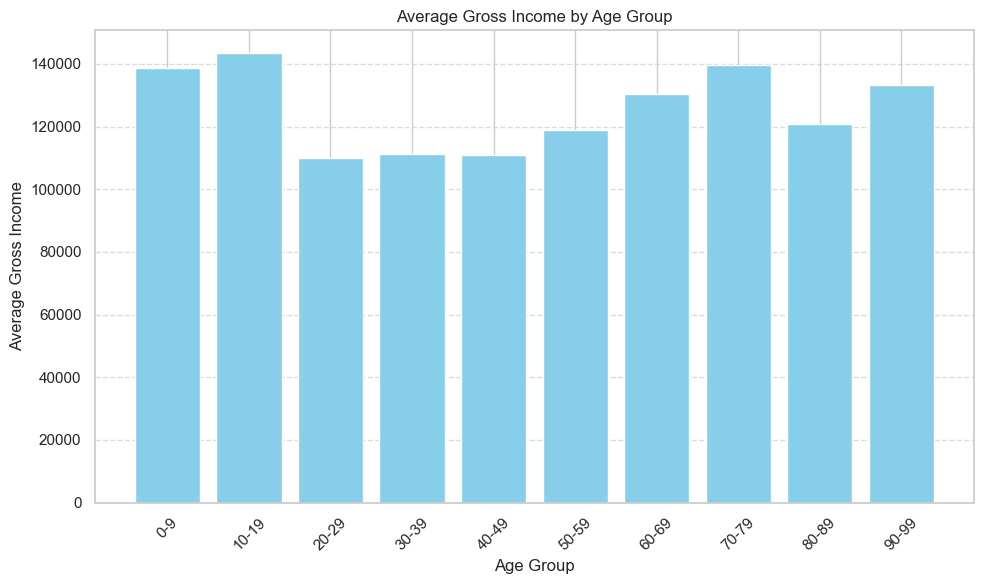

In [817]:
# Create age groups (10-year intervals) in a separate DataFrame
bins = range(0, 101, 10)  # Adjust the upper limit as needed
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # e.g., ['0-9', '10-19', ..., '90-99']

# Create a temporary DataFrame for age groups and gross income
temp_df = df[['age', 'gross_income']].copy()
temp_df['age_group'] = pd.cut(temp_df['age'], bins=bins, labels=labels, right=False)

# Calculate the average gross income for each age group
avg_gross_income = temp_df.groupby('age_group')['gross_income'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_gross_income['age_group'], avg_gross_income['gross_income'], color='skyblue')
plt.title('Average Gross Income by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Gross Income')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Except the spouse_employee_index, the other columns have very few NA values, hence we will replace NA values of spouse to 0 and remove the rest of the NA rows

/var/folders/c9/7rppvrpn09g_16cmvm8bjqlr0000gn/T/ipykernel_76250/3312318494.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


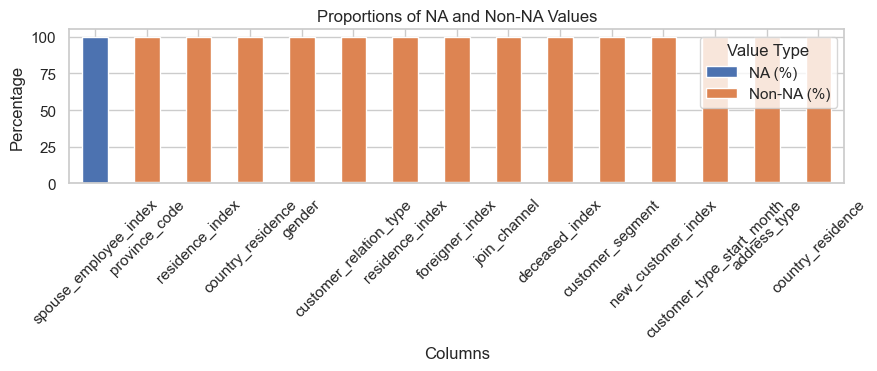

In [818]:
columns_with_na = [
    'spouse_employee_index',
    'province_code', 
    'residence_index',
    'country_residence', 
    'gender', 
    'customer_relation_type', 
    'residence_index', 
    'foreigner_index', 
    'join_channel', 
    'deceased_index', 
    'customer_segment', 
    'new_customer_index',
    'customer_type_start_month',
    'address_type',
    'country_residence'
]

# Calculate the proportion of NA and non-NA values
na_counts = df[columns_with_na].isna().sum()
total_counts = df[columns_with_na].shape[0]
non_na_counts = total_counts - na_counts

# Calculate proportions
na_proportions = na_counts / total_counts * 100
non_na_proportions = non_na_counts / total_counts * 100

# Create a DataFrame for proportions
proportions = pd.DataFrame({
    'NA (%)': na_proportions,
    'Non-NA (%)': non_na_proportions
})

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 2))
plt.title('Proportions of NA and Non-NA Values')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Value Type')
plt.tight_layout()
plt.show()


In [819]:
# Replace NA values in 'spouse_employee_index' with 0
df['spouse_employee_index'].fillna(0, inplace=True)
# Drop rows with NA values in the specified columns
df = df.dropna(subset=columns_with_na)

/var/folders/c9/7rppvrpn09g_16cmvm8bjqlr0000gn/T/ipykernel_76250/514752935.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['spouse_employee_index'].fillna(0, inplace=True)


#### Strip leading and trailing spaces from string columns

In [820]:
def strip_spaces(column):
    if column.dtype == 'object':  # Check if the column is of string type
        return column.str.strip()  # Strip leading and trailing spaces
    return column

# Apply the strip_spaces function to all columns in the DataFrame
df = df.apply(strip_spaces)

# Remove leading/trailing whitespace of seniority_months column and convert to numeric
df['seniority_months'] = pd.to_numeric(df['seniority_months'].str.strip(), errors='coerce')

### Combining columns

In [821]:
## Report_date and contract_start_date can be combined into contract_length by taking the difference between the two dates.
#This also allows the columns to be used as numerical columns which are required for SMOTE and logistic regression

date_columns = ['report_date', 'contract_start_date']  

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate the difference in days
df['contract_length'] = (df['report_date'] - df['contract_start_date']).dt.days

# Insert 'contract_length' in the same spot as 'contract_start_date'
start_date_index = df.columns.get_loc('contract_start_date')
df.insert(start_date_index, 'contract_length', df.pop('contract_length'))

# Drop the original 'contract_start_date' and 'report_date' columns
df = df.drop(['contract_start_date', 'report_date', 'customer_id'], axis='columns')


## 4) Data exploration
Here we use a correlation matrix to determine which columns to keep

### From the correlation matrix we found that the following 4 features: customer_type_start_month, spouse_employee_index, address_type, and country_residence are blank. This occured after removing all NA values which implies these columns only have one value. In addition primary_customer_status and last_primary_customer_date are highly correlated with 0.9 and activity index is correlated to customer_relation_type with -0.8, province_code and province_name are also highly correlated at 0.9 

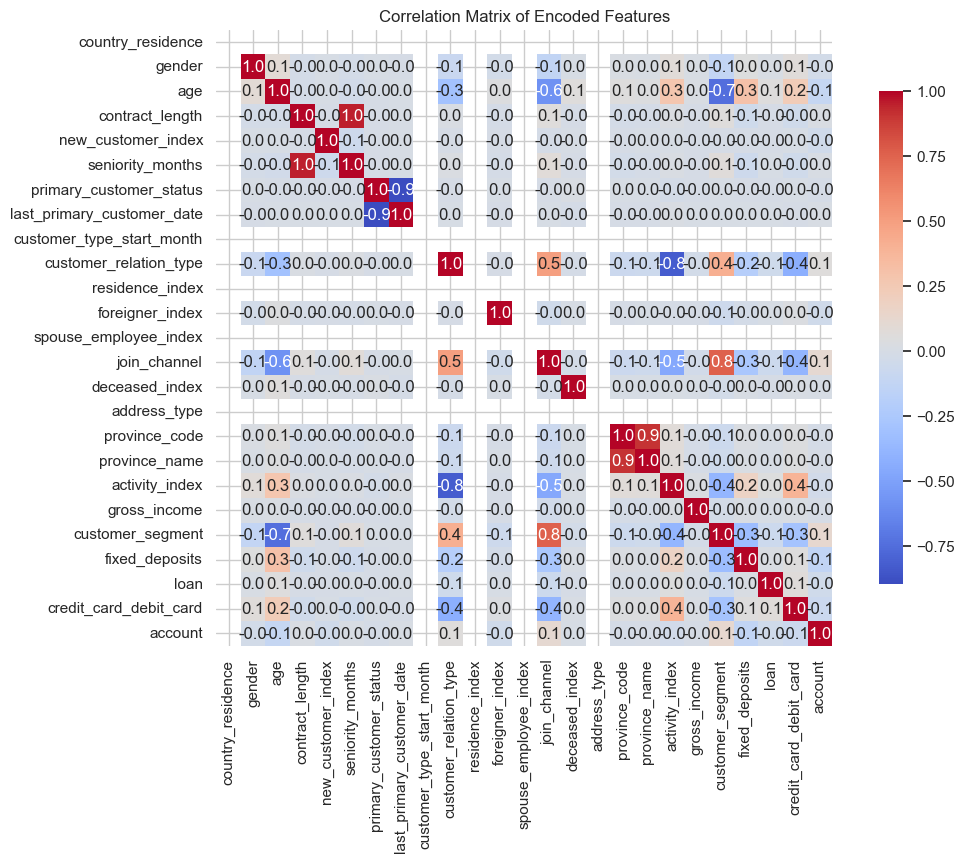

In [822]:
# Create a copy of the DataFrame to work with for encoding
encoded_df = df.copy()

# Identify categorical columns for label encoding
categorical_columns = encoded_df.select_dtypes(include=['category', 'object']).columns.tolist()

# Apply Label Encoder to categorical columns in encoded_df
label_encoder = LabelEncoder()
for col in categorical_columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

# Calculate the correlation matrix on encoded_df
correlation_matrix = encoded_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Encoded Features')
plt.show()



In [823]:
## this proves that these columns only have one value
# List of columns to check
columns_to_check = ['customer_type_start_month', 'spouse_employee_index', 'address_type', 'country_residence']

# Retrieve and print unique values for each specified column
unique_values = {col: df[col].unique() for col in columns_to_check}
for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")


Unique values in 'customer_type_start_month': [1.]
Unique values in 'spouse_employee_index': [0.]
Unique values in 'address_type': [1.]
Unique values in 'country_residence': ['ES']


### We will utilize SMOTE and logistic regression, which require our dataset to contain only numerical columns. Therefore, we need to encode categorical variables while minimizing the number of new columns created to reduce dimensionality, enhance training efficiency, and prevent overfitting. To achieve this, we will identify features with the most categories and consolidate those categories to lower their count.

/var/folders/c9/7rppvrpn09g_16cmvm8bjqlr0000gn/T/ipykernel_76250/30792082.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Unique Count', y='Column', data=unique_counts_df, palette='viridis')


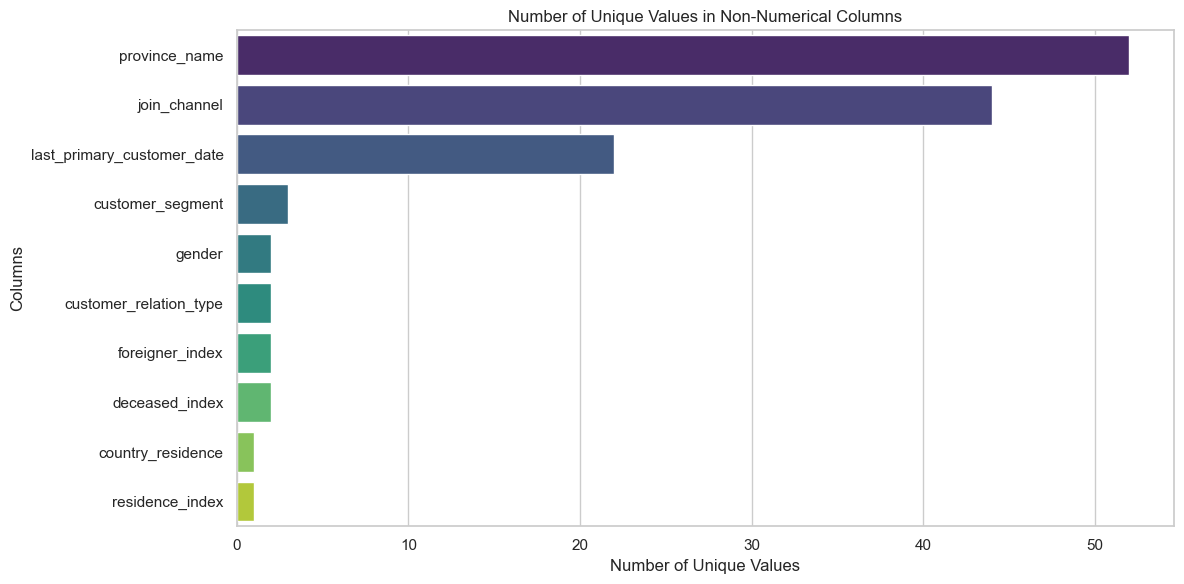

In [824]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List all non-numerical columns in the DataFrame
non_numerical_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Calculate the number of unique values for each non-numerical column
unique_counts = {col: df[col].nunique() for col in non_numerical_columns}

# Create a DataFrame from the unique counts
unique_counts_df = pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique Count'])

# Sort the DataFrame by 'Unique Count' in descending order
unique_counts_df = unique_counts_df.sort_values(by='Unique Count', ascending=False)

# Set the style for the plots
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Unique Count', y='Column', data=unique_counts_df, palette='viridis')

plt.title('Number of Unique Values in Non-Numerical Columns')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()


### We will reduce the number of classes in province_name by grouping the provinces into 5 regions of spain, namely north, south, east, west, and central. 

## 5) Feature selection and engineering

Rationale: After exploring the data, we decided to drop the columns:     
    'last_primary_customer_date',
    'activity_index',
    'province_code',
    'spouse_employee_index',
    'address_type'
In addition we will do one hot encoding for categorical data.

In [825]:
columns_to_drop = [
    'last_primary_customer_date',
    'activity_index',
    'province_code',
    'spouse_employee_index',
    'address_type'
]

# Drop columns if they exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### Checking the distribution of customers in the different provinces. We will be grouping them into 5 regions so we have to ensure the distribution is not too skewed. The most populated province is Madrid and Barcelonia, madrid is in the central and barcelonia is in the east


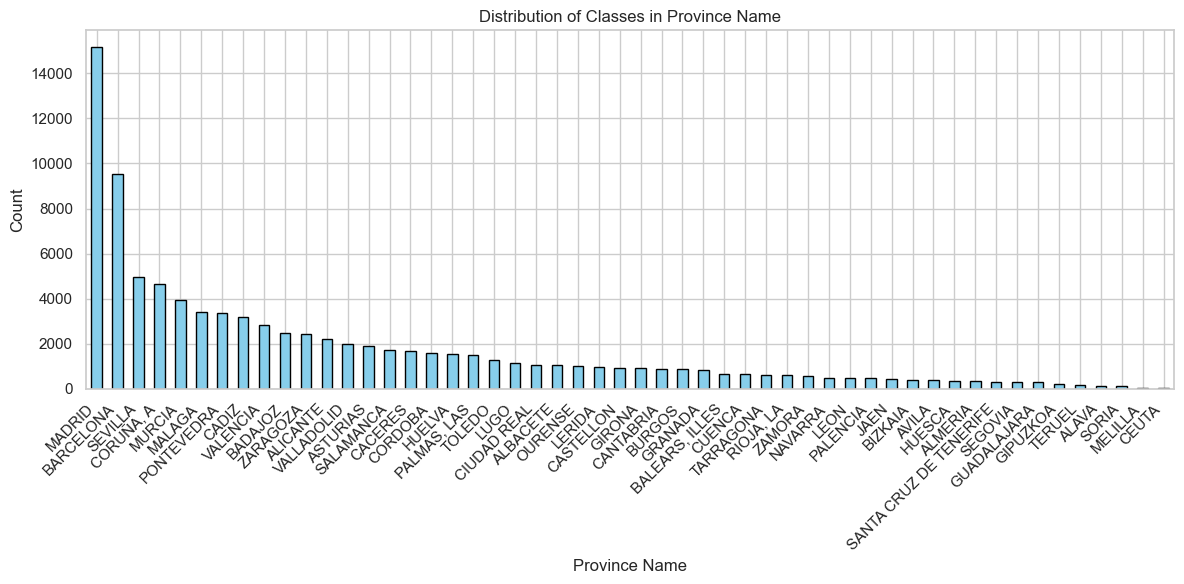

In [826]:
# Calculate the counts for each category in 'province_name'
province_counts = df['province_name'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
province_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Classes in Province Name')
plt.xlabel('Province Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()


#### Regrouping province into 5 regions


Rationale: Large number of classes in the categorical column "province_name", grouping the classes into regions prevents too 
many columns in the dataset when we one hot encode it. 

### From the plot the regions sufficiently evenly split the customers into 5 regions

In [827]:
# Changing province name to regions so less columns created via one hot encoding
region = []
for province in df['province_name']:
    if province in ['CIUDAD REAL', 'SALAMANCA', 'TOLEDO', 'SEGOVIA', 'MADRID', 'GUADALAJARA', 'ALBACETE', 'SORIA', 'CUENCA', 'AVILA']:
        region.append("CENTRAL")
    elif province in ['ALAVA', 'GIPUZKOA', 'PALENCIA', 'BURGOS', 'NAVARRA', 'CANTABRIA', 'BIZKAIA', 'RIOJA, LA', 'ZARAGOZA', 'TARRAGONA', 'LERIDA', 'HUESCA']:
        region.append("NORTH")
    elif province in ['CADIZ', 'JAEN', 'SEVILLA', 'PALMAS, LAS', 'CORDOBA', 'GRANADA', 'SANTA CRUZ DE TENERIFE', 'MELILLA', 'CEUTA', 'MALAGA']:
        region.append("SOUTH")
    elif province in ['VALENCIA', 'TERUEL', 'BALEARS, ILLES', 'CASTELLON', 'ALICANTE', 'MURCIA', 'ALMERIA', 'BARCELONA', 'GIRONA']:
        region.append("EAST")
    elif province in ['ZAMORA', 'CACERES', 'HUELVA', 'BADAJOZ', 'ASTURIAS', 'LEON', 'LUGO', 'CORUÑA, A', 'OURENSE', 'VALLADOLID', 'PONTEVEDRA']:
        region.append("WEST")
    else:
        region.append(None)  # Append None for unmatched provinces

# Assign the new region list to the DataFrame
df['region'] = region
df = df.drop(columns=['province_name'])  # Drop the original 'province_name' column

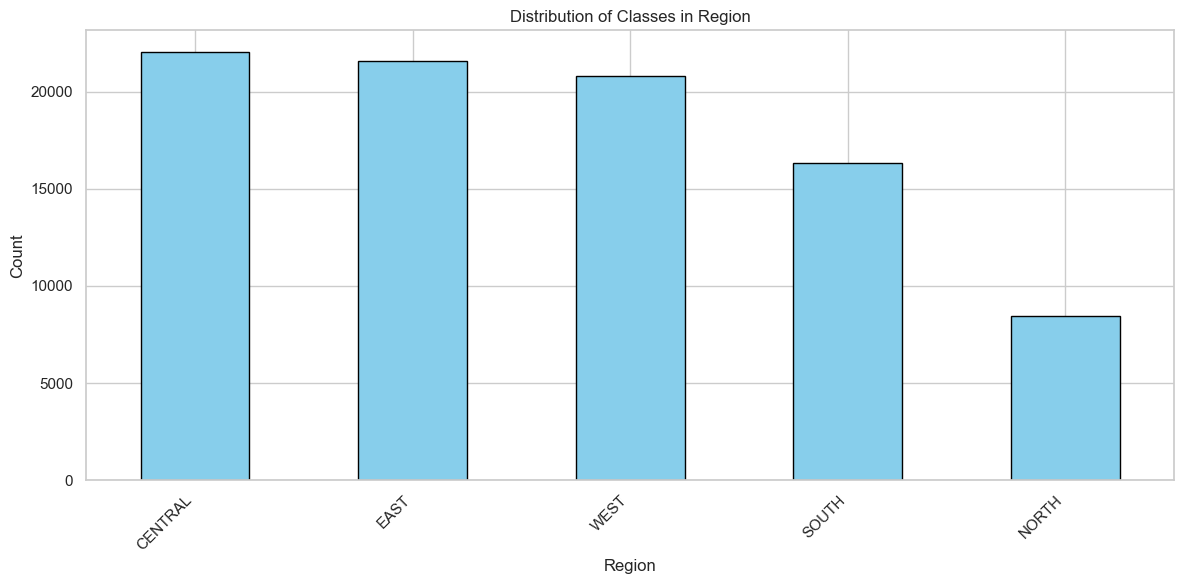

In [828]:

# Calculate the counts for each category in 'region'
region_counts = df['region'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
region_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Classes in Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()



### One hot encoding

Rationale: We are using SMOTE to handle imabalnced data and logistic regression for our recommendation system. Both require numerical data, hence categorical data must be one hot encoded

In [829]:
#Number of columns before one hot encoding
print("Number of columns in the DataFrame:", df.shape[1])


Number of columns in the DataFrame: 18


In [830]:
# Identify non-numeric columns for one-hot encoding
columns_to_encode = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()

# One-hot encode the categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

# One-hot encode the 'region' column
if 'region' in df.columns:
    df = pd.get_dummies(df, columns=['region'], drop_first=True)
    
# Convert True/False columns to 1/0
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)

In [831]:
#Number of columns after one hot encoding
print("Number of columns in the DataFrame:", df.shape[1])

Number of columns in the DataFrame: 71


###  Perform train_test_split

In [832]:
# Perform the 80/20 train-test split
df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices for both datasets to avoid misaligned indexing
df = df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save the test dataset to CSV
test_df.to_csv("clean_test_reco.csv", index=False)

### Perform SMOTE
Rationale:
- Solve the problem of imbalanced classes

In [833]:
#select an equal amount of each class, and use SMOTE to balance the rest

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Initialize the new balanced DataFrame
balanced_df = pd.DataFrame()

# Define the label columns to balance
label_columns = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']

# Set the maximum number of samples to take from any class
max_samples = number_of_each_class  # Adjust as needed

# Loop over each label column to balance it individually
for label in label_columns:
    # Separate the current label and the features
    y = df[label]
    X = df.drop(columns=label_columns)  # Keep all features but exclude other labels

    # Prepare the data to balance the 0 and 1 classes for the current label
    class_0 = df[df[label] == 0]
    class_1 = df[df[label] == 1]

    # Take a max of 'max_samples' or the available samples for each class
    sampled_class_0 = class_0.sample(n=min(len(class_0), max_samples), random_state=42)
    sampled_class_1 = class_1.sample(n=min(len(class_1), max_samples), random_state=42)

    # Combine the samples to form the data for SMOTE
    df_to_balance = pd.concat([sampled_class_0, sampled_class_1], ignore_index=True)

    # Separate features and the label for SMOTE
    X_balance = df_to_balance.drop(columns=label)
    y_balance = df_to_balance[label]

    # Apply SMOTE to balance the current label
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_balance, y_balance)

    # Create a DataFrame from the resampled data
    resampled_df = pd.DataFrame(X_resampled, columns=X_balance.columns)
    resampled_df[label] = y_resampled  # Add the resampled label back

    # Append the resampled data to the balanced_df
    balanced_df = pd.concat([balanced_df, resampled_df], ignore_index=True)


### Additional data cleaning steps

In [834]:
# Shuffle the final balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True).head(number_of_each_class*2*len(label_columns))

# Define the target columns to move to the front
columns_to_move = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']

# Remove the target columns from the DataFrame
remaining_columns = [col for col in balanced_df.columns if col not in columns_to_move]

# Add the target columns back to the front
balanced_df = balanced_df[columns_to_move + remaining_columns]

# Save the updated DataFrame to a new CSV file
balanced_df.to_csv(output_file_path, index=False)

print(f"CSV file successfully relabelled and saved to {output_file_path}")

CSV file successfully relabelled and saved to clean_train_reco.csv


### Checking class distribution for the y values
To check if SMOTE indeed solve the class imbalance problem. For 4 binary columns with each having possible values of either 0 or 1 there should be 8 classes to balance, hence a 50/50 split is impossible, the best proportion is about 12.5%. Hence SMOTE is used solely to create enough samples of the minority classes to train the model.

In [835]:

# List of columns to check for class imbalance
columns_to_check = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']

# Loop through each column and calculate class imbalance
for column in columns_to_check:
    class_counts = balanced_df[column].value_counts()
    total_count = class_counts.sum()
    
    # Calculate percentages
    percentages = (class_counts / total_count) * 100
    
    print(f"Class imbalance for '{column}':")
    print(f"Counts:\n{class_counts}")
    print(f"Percentages:\n{percentages}\n")


Class imbalance for 'fixed_deposits':
Counts:
fixed_deposits
0    102671
1     17329
Name: count, dtype: int64
Percentages:
fixed_deposits
0    85.559167
1    14.440833
Name: count, dtype: float64

Class imbalance for 'loan':
Counts:
loan
0    104836
1     15164
Name: count, dtype: int64
Percentages:
loan
0    87.363333
1    12.636667
Name: count, dtype: float64

Class imbalance for 'credit_card_debit_card':
Counts:
credit_card_debit_card
0    91186
1    28814
Name: count, dtype: int64
Percentages:
credit_card_debit_card
0    75.988333
1    24.011667
Name: count, dtype: float64

Class imbalance for 'account':
Counts:
account
1    96115
0    23885
Name: count, dtype: int64
Percentages:
account
1    80.095833
0    19.904167
Name: count, dtype: float64



### all the shit i should've noticed earlier (in the chunk below)
might fix it with the pipeline, worry about it next time i guess, it has to do with the user input
or just dont justify why it is there

In [837]:
#Have to drop 2 additional columns: country_residence','customer_type_start_month'.

KeyError: 'customer_type_start_month'